In [ ]:
class WeightedSum(Add):
  def __init__(self, alpha = 0.0, **kwargs):
    super(WeightedSum, self).__init__(**kwargs)
    self.alpha = backend.variable(alpha, name = 'ws_alpha')

  def _merge_function(self, inputs):
    assert (len(inputs) == 2)
    out = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
    return out  

In [ ]:
# #starting with 4x4 images

# in_image = Input(shape=(4,4,3))
# # conv 1x1
# g = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
# g = LeakyReLU(alpha=0.2)(g)
# # conv 3x3 (output block)
# g = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)
# # conv 4x4
# g = Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)
# # dense output layer
# g = Flatten()(g)
# out_class = Dense(1)(g)
# # define model
# model = Model(in_image, out_class)
# # compile model
# model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))

In [ ]:
# old_model = model
# # get shape of existing model
# in_shape = list(old_model.input.shape)
# # define new input shape as double the size
# input_shape = (in_shape[-2].value*2, in_shape[-2].value*2, in_shape[-1].value)
# in_image = Input(shape=input_shape)
# # define new input processing layer
# g = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
# g = LeakyReLU(alpha=0.2)(g)
# # define new block
# g = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)
# g = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(g)
# g = BatchNormalization()(g)
# g = LeakyReLU(alpha=0.2)(g)
# g = AveragePooling2D()(g)
# # downsample the new larger image
# downsample = AveragePooling2D()(in_image)
# # connect old input processing to downsampled new input
# block_old = old_model.layers[1](downsample)
# block_old = old_model.layers[2](block_old)
# # fade in output of old model input layer with new input
# g = WeightedSum()([block_old, g])
# # skip the input, 1x1 and activation for the old model
# for i in range(3, len(old_model.layers)):
# 	g = old_model.layers[i](g)
# # define straight-through model
# model = Model(in_image, g)
# # compile model
# model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))


In [ ]:
def add_discriminator_block(old_model, n_input_layers=3):
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2].value*2, in_shape[-2].value*2, in_shape[-1].value)
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]

In [ ]:
# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 64)   256         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 16, 16, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 64)   36928       leaky_re_lu_9[0][0]              
______________________________________________________________________________________

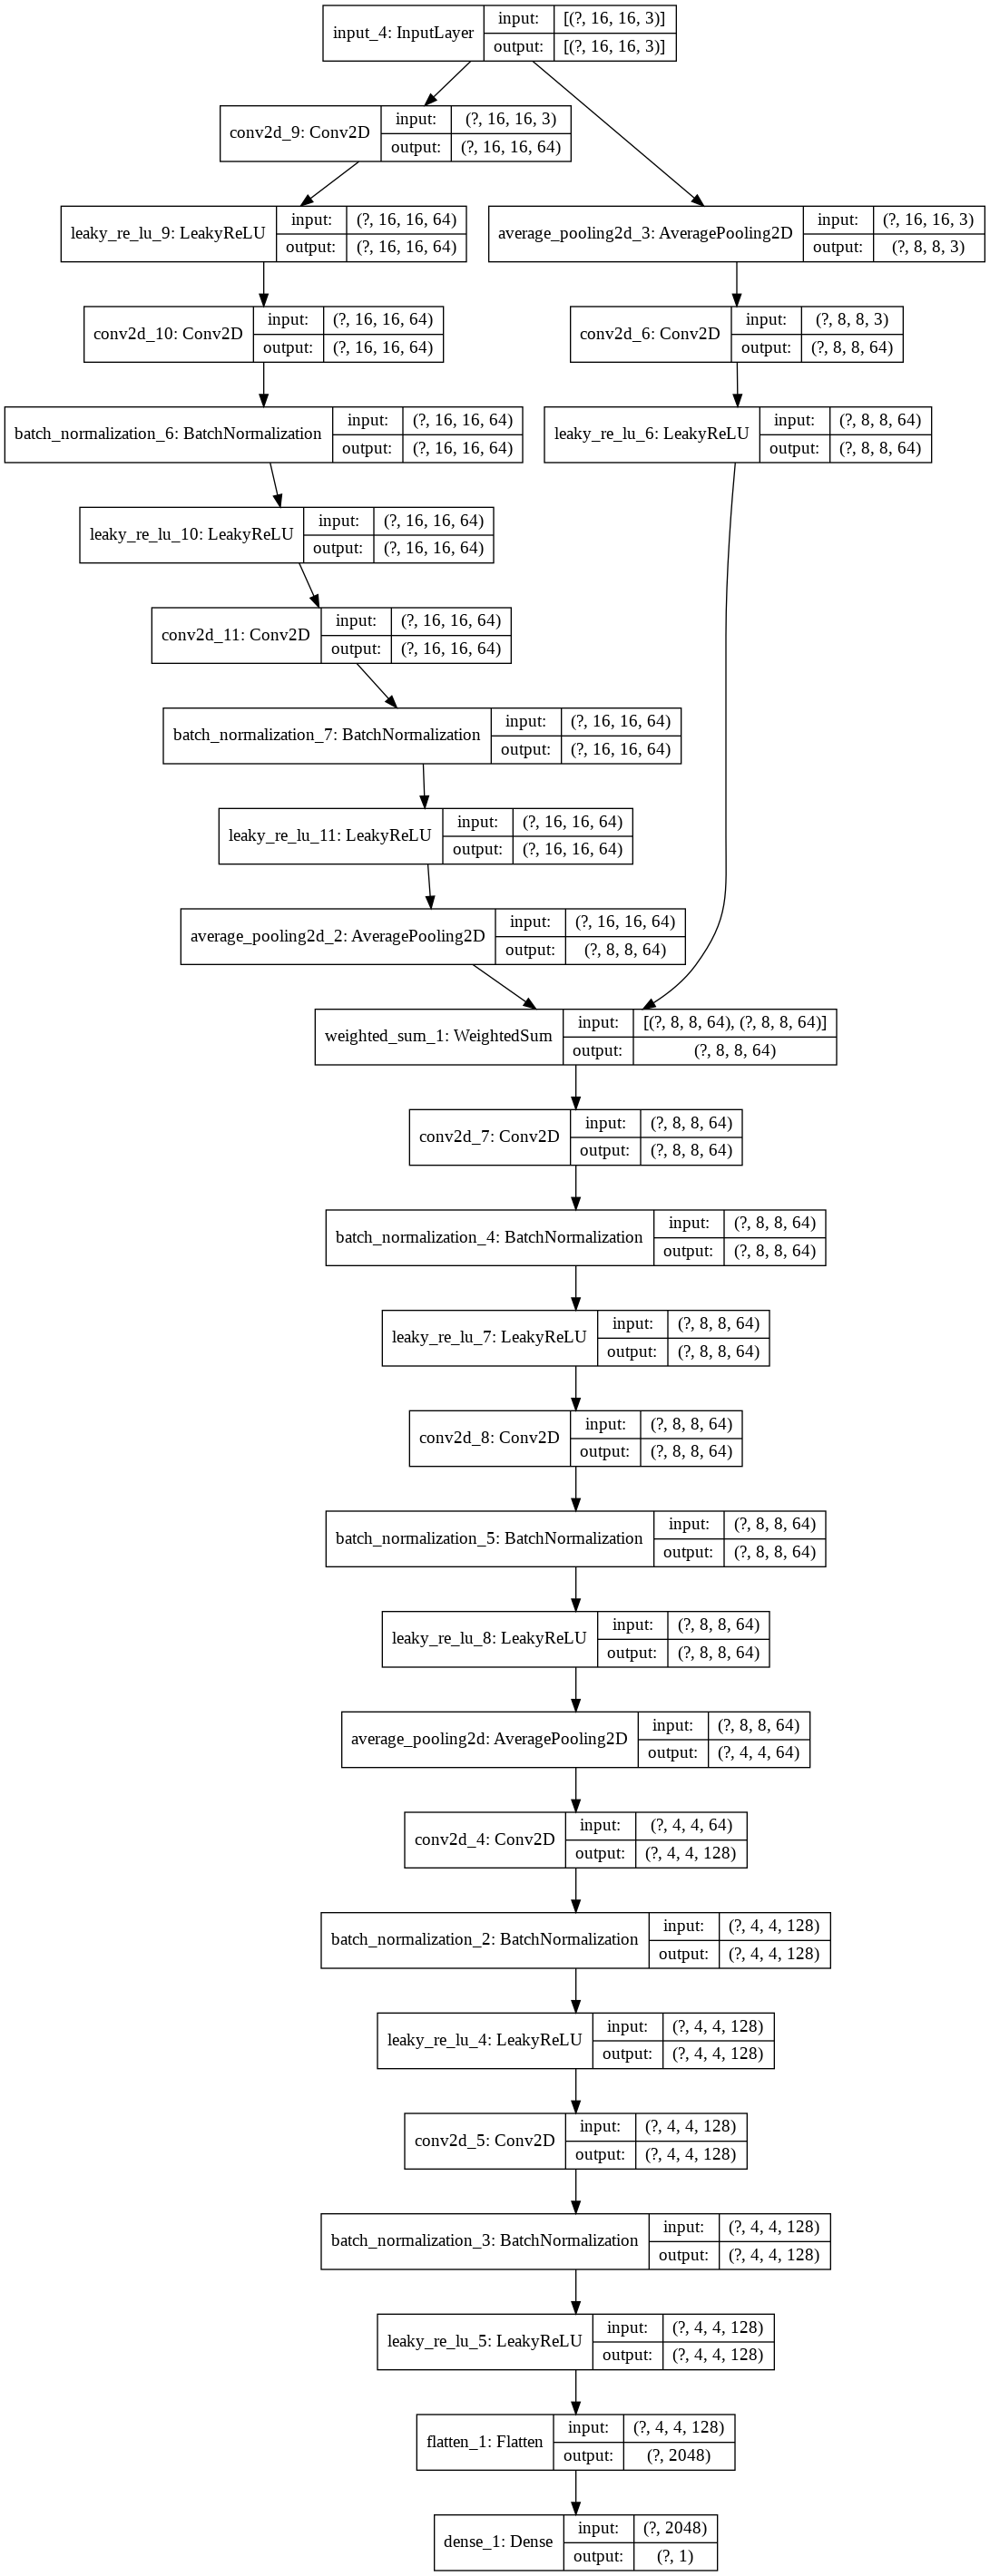

In [4]:
# example of defining discriminator models for the progressive growing gan
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.utils.vis_utils import plot_model
from keras import backend

# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]
# define the discriminator models for each image resolution

def define_discriminator(n_blocks, input_shape=(4,4,3)):
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# define models
discriminators = define_discriminator(3)
# spot check
m = discriminators[2][1]
m.summary()
plot_model(m, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [2]:
shape = list((4, 4, 3))
print(shape[-2])

4


Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 16, 16, 64)   256         input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 16, 16, 64)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 16, 16, 64)   36928       leaky_re_lu_21[0][0]             
______________________________________________________________________________________

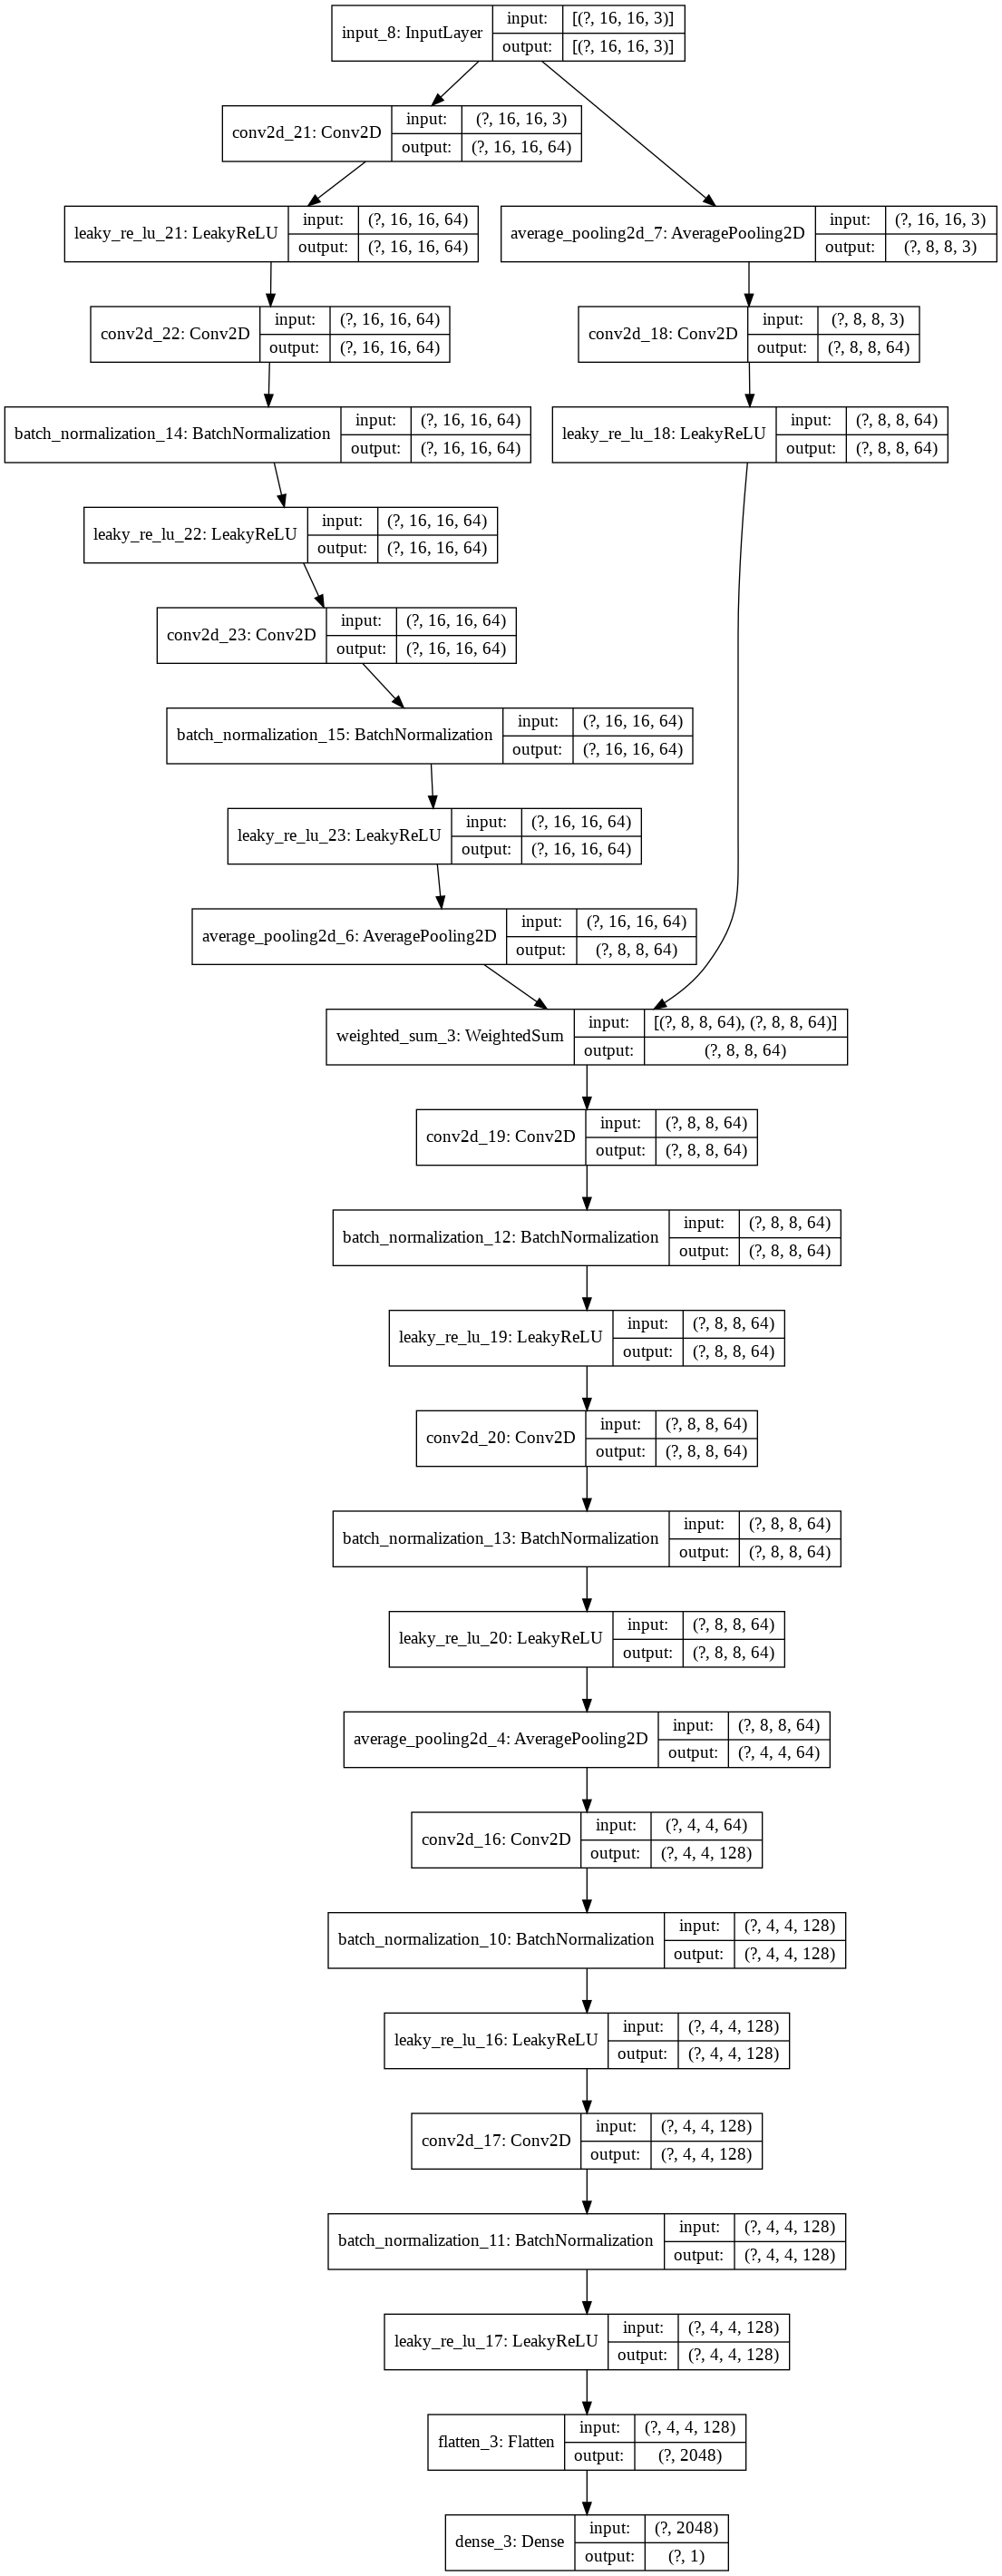

In [6]:
# example of defining discriminator models for the progressive growing gan
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.utils.vis_utils import plot_model
from keras import backend

# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]

# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# define models
discriminators = define_discriminator(3)
# spot check
m = discriminators[2][1]
m.summary()
plot_model(m, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
# example of defining composite models for the progressive growing gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.utils.vis_utils import plot_model
from keras import backend

# weighted sum output
class WeightedSum(Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = backend.variable(alpha, name='ws_alpha')

	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

# add a discriminator block
def add_discriminator_block(old_model, n_input_layers=3):
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
	in_image = Input(shape=input_shape)
	# define new input processing layer
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# define new block
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = Model(in_image, d)
	# compile model
	model1.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = Model(in_image, d)
	# compile model
	model2.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]

# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	model_list = list()
	# base model input
	in_image = Input(shape=input_shape)
	# conv 1x1
	d = Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = Flatten()(d)
	out_class = Dense(1)(d)
	# define model
	model = Model(in_image, out_class)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# add a generator block
def add_generator_block(old_model):
	# get the end of the last block
	block_end = old_model.layers[-2].output
	# upsample, and define new block
	upsampling = UpSampling2D()(block_end)
	g = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(upsampling)
	g = BatchNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	g = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(g)
	g = BatchNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# add new output layer
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer='he_normal')(g)
	# define model
	model1 = Model(old_model.input, out_image)
	# get the output layer from old model
	out_old = old_model.layers[-1]
	# connect the upsampling to the old output layer
	out_image2 = out_old(upsampling)
	# define new output image as the weighted sum of the old and new models
	merged = WeightedSum()([out_image2, out_image])
	# define model
	model2 = Model(old_model.input, merged)
	return [model1, model2]

# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	model_list = list()
	# base model latent input
	in_latent = Input(shape=(latent_dim,))
	# linear scale up to activation maps
	g  = Dense(128 * in_dim * in_dim, kernel_initializer='he_normal')(in_latent)
	g = Reshape((in_dim, in_dim, 128))(g)
	# conv 4x4, input block
	g = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(g)
	g = BatchNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 3x3
	g = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(g)
	g = BatchNormalization()(g)
	g = LeakyReLU(alpha=0.2)(g)
	# conv 1x1, output block
	out_image = Conv2D(3, (1,1), padding='same', kernel_initializer='he_normal')(g)
	# define model
	model = Model(in_latent, out_image)
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_generator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss='mse', optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

# define models
discriminators = define_discriminator(3)
# define models
generators = define_generator(100, 3)
# define composite models
composite = define_composite(discriminators, generators)

In [10]:
def update_fadein(models, step, n_steps):
  alpha = step/(n_steps-1)
  for model in models:
    for layer in model.layers:
      if isinstance(layer, WeightedSum):
        backend.set_value(layer.alpha, alpha)

In [13]:
def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein = False):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  n_steps = bat_per_epo * n_epochs
  half_batch = int(n_batch / 2)
  for i in range(n_steps):
  # update alpha for all WeightedSum layers when fading in new blocks
    if fadein:
      update_fadein([g_model, d_model, gan_model], i, n_steps)
    # prepare real and fake samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator model
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    # update the generator via the discriminator's error
    z_input = generate_latent_points(latent_dim, n_batch)
    y_gan = ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(z_input, y_gan)
    # summarize loss on this batch
    print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

In [11]:
def scale_dataset(images, new_size):
  images_list = list()
  for image in images:
    new_image = resize(image, new_size, 0)
    images_list.append(new_image)
  return asarray(images_list)  

In [ ]:
# g_normal = g_models[0][0]  #this is for the baseline model
# d_normal = d_models[0][0]
# gan_normal = gan_models[0][0]

# gen_shape = g_normal.output_shape
# scaled_data = scale_dataset(dataset, gen_shape[1:])
# print('Shape:', scaled_data.shape)
# train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm, n_batch)

In [ ]:
# #this is for the new layers after the 4x4

# for i in range(1, len(g_models)):
#   [g_normal, g_fadein] = g_models[i]
#   [d_normal, d_fadein] = d_models[i]
#   [gan_normal, gan_fadein] = gan_models[i]
#   gen_shape = g_normal.output_shape
#   scaled_data = scale_dataset(dataset, gen_shape[1:])
#   print('Shape:', scaled_data.shape)
#   train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein, n_batch)
#   train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm, n_batch)



In [15]:
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm, n_batch)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein, n_batch, True)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm, n_batch)

In [ ]:
n_blocks = 3
latent_dims = 100

d_models = define_discriminator(n_blocks)
g_models = define_generator(100, n_blocks)
gan_models = define_composite(d_models, g_models)
dataset = load_real_samples()

train(g_models, d_models, gan_models, dataset, latent_dim, 100, 100, 16)